# Most Outdoors-y Neighborhood in Pittsburgh

In [62]:
import pandas as pd
import json
import geopandas as gpd
from shapely.geometry import Polygon, Point
from shapely.ops import cascaded_union
import matplotlib
import matplotlib.pyplot as plt

Load Pittsburgh neighborhoods into GeoDataFrame

In [63]:
neighborhoods = gpd.read_file("https://pghgishub-pittsburghpa.opendata.arcgis.com/datasets/dbd133a206cc4a3aa915cb28baa60fd4_0.geojson?outSR=%7B%22latestWkid%22%3A2272%2C%22wkid%22%3A102729%7D")
neighborhoods.columns

Index(['objectid', 'fid_blockg', 'statefp10', 'countyfp10', 'tractce10',
       'blkgrpce10', 'geoid10', 'namelsad10', 'mtfcc10', 'funcstat10',
       'aland10', 'awater10', 'intptlat10', 'intptlon10', 'shape_leng',
       'fid_neighb', 'area', 'perimeter', 'neighbor_', 'neighbor_i', 'hood',
       'hood_no', 'acres', 'sqmiles', 'dpwdiv', 'unique_id', 'sectors',
       'shape_le_1', 'shape_ar_1', 'page_number', 'plannerassign',
       'created_user', 'created_date', 'last_edited_user', 'last_edited_date',
       'temp', 'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')

<AxesSubplot:>

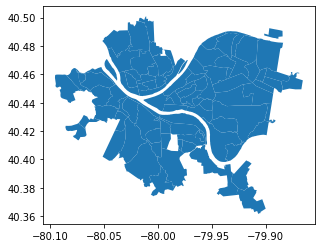

In [64]:
neighborhoods.plot()

Create convenience method for getting neighborhood from lat-long

In [65]:
def getNeighborhood(latitude, longitude):
    return getNeighborhood(Point(longitude, latitude))

def getNeighborhood(point):
    neighborhoods_containing = neighborhoods[neighborhoods["geometry"].contains(point)]

    if len(neighborhoods_containing) < 1:
        return None

    return neighborhoods_containing.iloc[0]["hood"]

Create single polygon that represents the region of all neighborhoods

<AxesSubplot:>

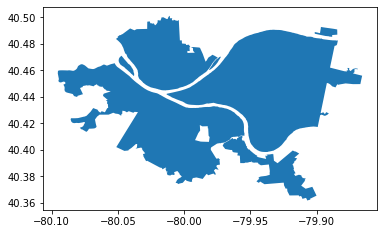

In [66]:
all_neighborhoods_shape = cascaded_union(neighborhoods["geometry"])
gpd.GeoSeries(all_neighborhoods_shape).plot()

Create convenience method for determining if a point is contained within any neighborhood

In [67]:
def inNeighborhood(latitude, longitude):
    return inNeighborhood(Point(longitude, latitude))

def inNeighborhood(point):
    return all_neighborhoods_shape.contains(point)

## Trees in Pittsburgh

In [68]:
trees = pd.read_csv("https://data.wprdc.org/datastore/dump/1515a93c-73e3-4425-9b35-1cd11b2196da", dtype={"address_number": str})
trees = gpd.GeoDataFrame(trees, geometry=gpd.points_from_xy(trees.longitude, trees.latitude))

In [69]:
trees.head()

,id,address_number,street,common_name,scientific_name,height,width,growth_space_length,growth_space_width,growth_space_type,...,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude,geometry
0,754166088,7428,MONTICELLO ST,Stump,Stump,0.0,0.0,10.0,2.0,Well or Pit,...,9.0,13.0,4.200313e+10,2.0,13.0,5.0,3-17,40.458169,-79.889724,POINT (-79.88972 40.45817)
1,1946899269,220,BALVER AVE,Linden: Littleleaf,Tilia cordata,0.0,0.0,99.0,99.0,Open or Unrestricted,...,2.0,28.0,4.200356e+10,5.0,28.0,6.0,1-19,40.429269,-80.067868,POINT (-80.06787 40.42927)
2,1431517397,2822,SIDNEY ST,Maple: Red,Acer rubrum,22.0,6.0,6.0,3.0,Well or Pit,...,3.0,16.0,4.200316e+10,3.0,16.0,3.0,4-24,40.426797,-79.965035,POINT (-79.96503 40.42680)
3,994063598,608,SUISMON ST,Maple: Freeman,Acer x freemanii,25.0,10.0,3.0,3.0,Well or Pit,...,1.0,23.0,4.200356e+10,1.0,23.0,1.0,1-6,40.455503,-79.999276,POINT (-79.99928 40.45550)
4,1591838573,1135,N NEGLEY AVE,Maple: Norway,Acer platanoides,52.0,13.0,99.0,99.0,Open or Unrestricted,...,7.0,11.0,4.200311e+10,2.0,11.0,5.0,3-9,40.476667,-79.924106,POINT (-79.92411 40.47667)


Filter out the trees that have invalid lat-long data or are not contained within the Pittsburgh neighborhoods.

In [70]:
trees = trees[trees["geometry"].map(inNeighborhood)]

Analyze the various types of trees.

In [71]:
trees["common_name"].value_counts()

Maple: Norway            3717
Maple: Red               3421
London planetree         3224
Pear: Callery            2969
Vacant Site Small        2418
                         ... 
Pecan                       1
Fir: Fraser                 1
Serviceberry: Western       1
Juniper: spp.               1
Fringetree: Chinese         1
Name: common_name, Length: 233, dtype: int64

Analyze the various conditions of trees.

In [72]:
trees["condition"].value_counts()

Good         16402
Fair         16232
Poor          4615
Dead          1098
Critical       988
Very Good      550
Excellent       79
Name: condition, dtype: int64

Filter out trees without defined condition

In [73]:
acceptable_conditions = ["Dead", "Critical", "Poor", "Fair", "Good", "Very Good", "Excellent"]
trees = trees[trees["condition"].map(lambda x: x in acceptable_conditions)]
trees["condition"].value_counts()

Good         16402
Fair         16232
Poor          4615
Dead          1098
Critical       988
Very Good      550
Excellent       79
Name: condition, dtype: int64

Plot the trees in Pittsburgh and color-code their qualities (blue is best, red is worst)

Text(0.5, 1.0, 'Trees and Their Qualities in Pittsburgh')

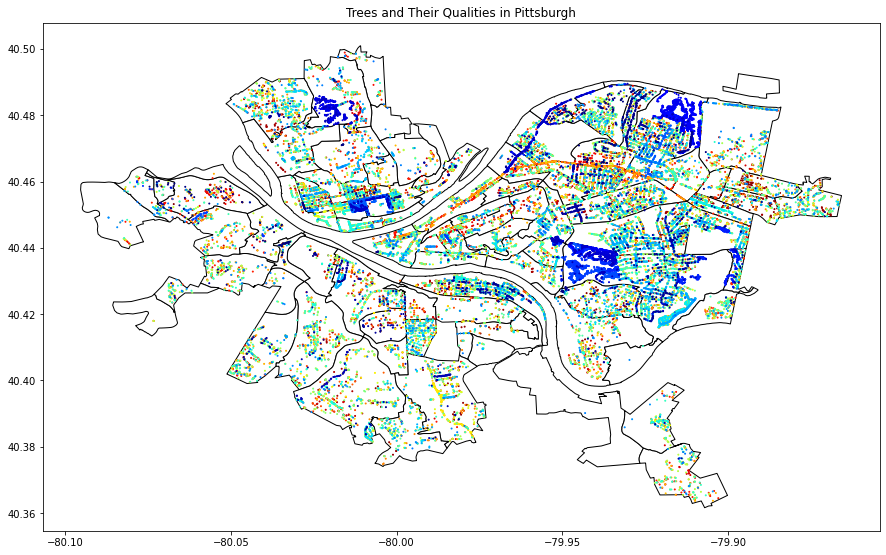

In [74]:
trees["condition"] = trees["condition"].replace({
    "Dead": -3,
    "Critical": -2,
    "Poor": -1,
    "Fair": 0,
    "Good": 1,
    "Very Good": 2,
    "Excellent": 3,
})

base = neighborhoods.plot(color="white", edgecolor="black", figsize=(15, 15))
trees.plot(ax=base, marker="o", markersize=1, c=trees["condition"], cmap='jet_r')
plt.title("Trees and Their Qualities in Pittsburgh")

Get the total tree value per Pittsburgh neighborhood

In [75]:
trees_avg_value = pd.DataFrame(trees.groupby("neighborhood")["property_value_benefits_dollarvalue"].sum())

Text(0.5, 1.0, 'Pittsburgh Neighborhoods by Total Tree Value')

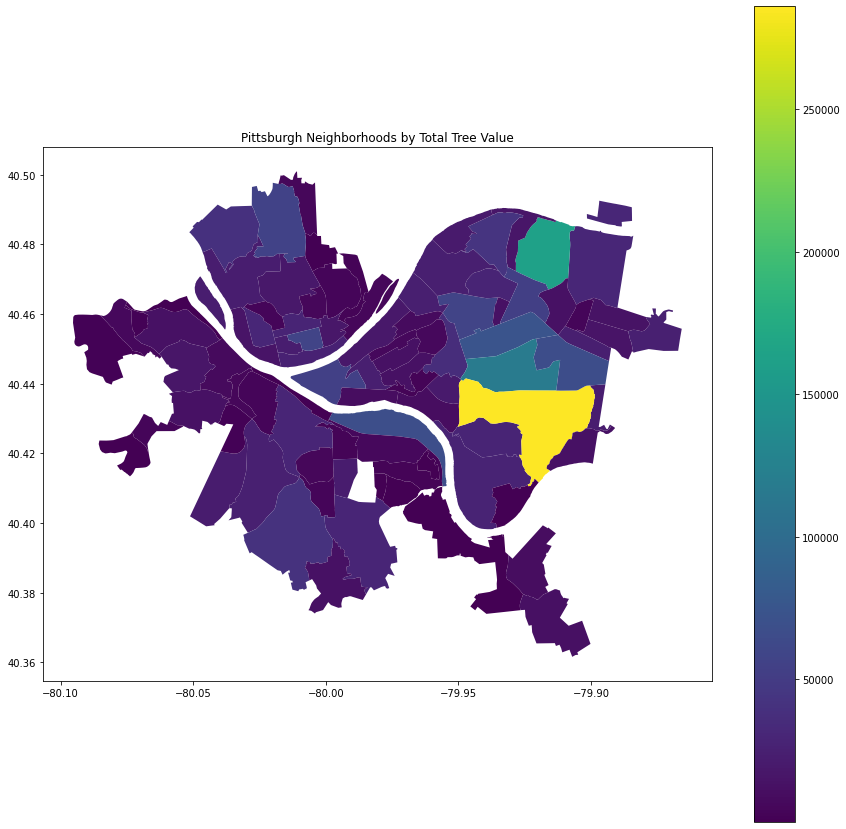

In [76]:
neighborhood_tree_value = neighborhoods.merge(trees_avg_value, left_on="hood", right_on="neighborhood")
neighborhood_tree_value.plot(column="property_value_benefits_dollarvalue", legend=True, figsize=(15, 15))
plt.title("Pittsburgh Neighborhoods by Total Tree Value")

Get the top 5 neighborhoods by tree value.

In [77]:
neighborhood_tree_value_slice = neighborhood_tree_value.sort_values("property_value_benefits_dollarvalue", ascending=False).round(decimals=2)[["hood", "property_value_benefits_dollarvalue"]]
neighborhood_tree_value_slice.head(5)

,hood,property_value_benefits_dollarvalue
50,Squirrel Hill South,286064.04
25,Highland Park,162529.12
44,Squirrel Hill North,118339.75
31,Shadyside,74661.57
61,South Side Flats,67106.48


### Rating PGH Neighborhoods by Walkability
###### The walk scores in this data set were provided by Walk Score
###### Points are awarded in different categories based on a locations proximity to the amenities included in that category. Scores range from 0-100

#### Notebook Imports/Reading Files

In [101]:
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline

walk_data = pd.read_csv("walkability.csv")
tract_guide = pd.read_csv("census_tracts.csv")
neighborhoods = gpd.read_file("https://pghgishub-pittsburghpa.opendata.arcgis.com/datasets/dbd133a206cc4a3aa915cb28baa60fd4_0.geojson?outSR=%7B%22latestWkid%22%3A2272%2C%22wkid%22%3A102729%7D")

#### Notebook Methods:

###### getHoodFromTract: Method that returns a PGH neighbrohood based on the given census tract
###### matchTractToHood: Method that creates a list of neighborhoods matched to the tracts in the neighborhoods GDF
###### matchTractToScore: Method that creates a list of scores matched to the tracts in the neighborhoods GDF

In [102]:
def getHoodFromTract(tract):
    for g_tracts in tract_guide["tractce10"].iteritems():
        if (tract[1] == g_tracts[1]):
            return (tract_guide["hood"][g_tracts[0]])
        
def matchTractToHood(tract):
    for d_tracts in walk_data["Census Tract"].iteritems():
            if(int(d_tracts[1]) == int(tract[1])):                
                 pgh_hoods.append(hood_ser[d_tracts[0]]) 
def matchTractToScore(tract):
    for d_tracts in walk_data["Census Tract"].iteritems():
            if(int(d_tracts[1]) == int(tract[1])):                
                 pgh_scores.append(int(walk_score_ser[d_tracts[0]]))   

###### Combines data from walkability.csv and census_tracts.csv to create a dataframe that matches neighborhoods to walk scores and census tracts.

In [103]:
hood_list = [] 
for d_tracts in walk_data['Census Tract'].iteritems():
        hood_list.append(getHoodFromTract(d_tracts))
               
hood_ser = pd.Series(hood_list)
tract_ser = pd.Series(walk_data["Census Tract"])
walk_score_ser = pd.Series(walk_data["Walk Score"])

combine = {'Tract': tract_ser,'Hood': hood_ser, 'Walk Score': walk_score_ser}
hood_by_score = pd.DataFrame(combine)

hood_by_score = hood_by_score.dropna()
print(hood_by_score.sample(10))

      Tract                      Hood  Walk Score
16    70300                 Shadyside          91
56   141000             Regent Square          71
368  561900  Lincoln-Lemington-Belmar          25
87   260700               Perry North          29
90   261400               Perry South          49
78   202300                Banksville          48
369  562000             North Oakland          75
394  980700               South Shore          72
71   191500          Mount Washington          45
53   140500        Point Breeze North          72


***Average duplicates***

In [104]:
hood_by_score = hood_by_score.groupby('Hood')['Walk Score'].mean()
hood_by_score.head()

Hood
Allegheny West       86.0
Allentown            63.0
Arlington            26.0
Banksville           48.0
Bedford Dwellings    77.0
Name: Walk Score, dtype: float64

###### Alters the neighborhoods GeoDataFrame by adding two new columns and creates a map of PGH colored by walk scores. 

<class 'pandas.core.series.Series'>


<AxesSubplot:>

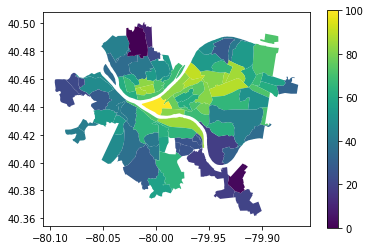

In [105]:
pgh_hoods = []
pgh_scores = []

for n_tracts in neighborhoods["tractce10"].iteritems():
    if (n_tracts[1] == ' '): pgh_hoods.append(" ")    
    else: matchTractToHood(n_tracts)

for n_tracts in neighborhoods["tractce10"].iteritems():
    if (n_tracts[1] == ' '): pgh_scores.append(0)    
    else: matchTractToScore(n_tracts)
                
neighborhoods["Neighborhood"] = pgh_hoods
neighborhoods["Score"] = pgh_scores
print(type(neighborhoods["Score"]))

neighborhoods.plot(column="Score", legend=True)

#### Listing the 5 Best/Worst Neighborhoods by Walkability
###### From the code below we see the best rated neighborhood for walkability is the Central Business District, with a perfect score of 100, while the worst rated neighborhood is New Homestead with a very low score of 2. 

In [107]:
sorted_scores = hood_by_score.sort_values()

print(sorted_scores.tail(), "\n")
print(sorted_scores.head())

Hood
Allegheny West                86.0
Shadyside                     86.6
Polish Hill                   88.0
Lower Lawrenceville           91.0
Central Business District    100.0
Name: Walk Score, dtype: float64 

Hood
New Homestead         2.0
Summer Hill           9.0
Lincoln Place        20.0
Windgap              22.0
Northview Heights    23.0
Name: Walk Score, dtype: float64


#### Analyzing the distribution of walk scores

###### Generating a statistical summary and box plot of the walk score distribution.
###### The final line of the following code is meant to print outliers, but there appear to be none in this dist.
###### The distribution is skewed to the left, showing that some neighborhoods scored very low, despite a mean of ~58.
###### The high variance of this distribution shows that walkability throughout Allegheny County differs greatly.

count     79.000000
mean      57.346414
std       20.661794
min        2.000000
25%       43.583333
50%       59.200000
75%       72.000000
max      100.000000
Name: Walk Score, dtype: float64
(array([], dtype=int64),)


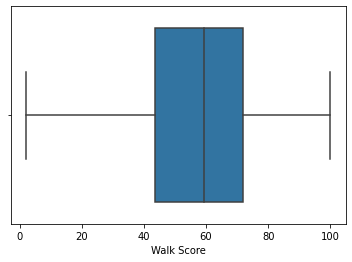

In [109]:
print(sorted_scores.describe())
sns.boxplot(x=sorted_scores)
z=np.abs(stats.zscore(sorted_scores))
print(np.where(z>3))

## Playing Fields in Pittsburgh

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
##read initial data
field = pd.read_csv('pittsburgh-playing-fields.csv')
##take only values from the neighborhood column
numField = field["neighborhood"].value_counts()
##list all neighborhoods and number of fields in order
numField.head(40)

Brighton Heights            7
Brookline                   6
South Side Slopes           6
Squirrel Hill South         5
Carrick                     5
Hazelwood                   4
Highland Park               4
Lower Lawrenceville         4
Sheraden                    3
Shadyside                   3
Morningside                 3
Beltzhoover                 3
Beechview                   3
Mount Washington            3
Troy Hill                   3
South Side Flats            2
Bedford Dwellings           2
Perry North                 2
Manchester                  2
Central Lawrenceville       2
Spring Hill-City View       2
Westwood                    2
Lincoln-Lemington-Belmar    2
Elliott                     2
South Oakland               2
Crafton Heights             2
Banksville                  2
Regent Square               2
Allegheny Center            2
Greenfield                  2
Upper Lawrenceville         1
Polish Hill                 1
Homewood South              1
East Liber

<AxesSubplot:>

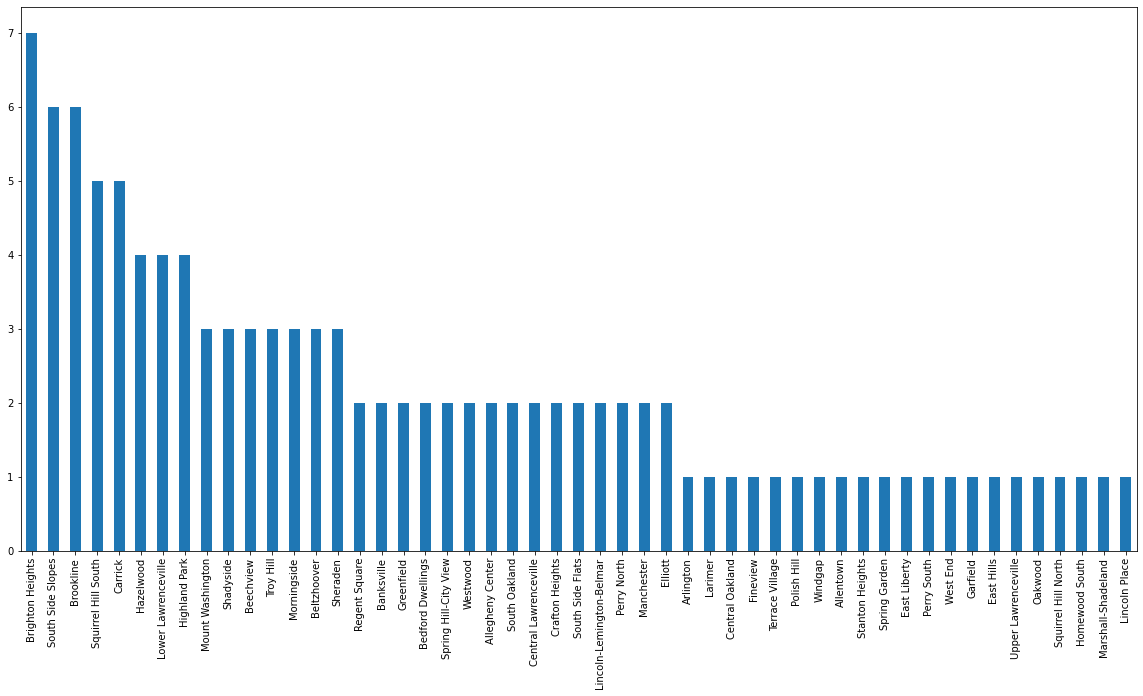

In [7]:
##plot graph
numField.plot.bar(figsize = (20,10))

# Best Neighborhood in Pittsburgh - Decision

Merge all per-neighborhood metrics into single DataFrame.

In [116]:
SCORE_BASIS = ["property_value_benefits_dollarvalue", "Walk Score"]

combined_metrics = neighborhood_tree_value_slice.merge(sorted_scores, left_on="hood", right_on="Hood")
combined_metrics

,hood,property_value_benefits_dollarvalue,Walk Score
0,Squirrel Hill South,286064.04,59.200000
1,Highland Park,162529.12,49.333333
2,Squirrel Hill North,118339.75,72.666667
3,Shadyside,74661.57,86.600000
4,South Side Flats,67106.48,80.000000
...,...,...,...
73,Arlington,2666.42,26.000000
74,Spring Garden,2305.37,54.000000
75,St. Clair,997.70,26.000000
76,Northview Heights,430.86,23.000000


In [117]:
def normalize_series(series):
    return series / series.max()

for col_to_normalize in SCORE_BASIS:
    combined_metrics[col_to_normalize] = normalize_series(combined_metrics[col_to_normalize])
    
combined_metrics.head()

,hood,property_value_benefits_dollarvalue,Walk Score
0,Squirrel Hill South,1.000000,0.592000
1,Highland Park,0.568156,0.493333
2,Squirrel Hill North,0.413683,0.726667
3,Shadyside,0.260996,0.866000
4,South Side Flats,0.234586,0.800000


## Define equally-weighted Outdoors-y Metric for Neighborhoods

In [123]:
combined_metrics["Outdoors Score"] = combined_metrics[SCORE_BASIS].sum(axis=1) / len(SCORE_BASIS)

In [126]:
combined_metrics.sort_values(by="Outdoors Score", ascending=False).head(5)

,hood,property_value_benefits_dollarvalue,Walk Score,Outdoors Score
0,Squirrel Hill South,1.000000,0.592000,0.796000
8,Central Business District,0.188429,1.000000,0.594215
2,Squirrel Hill North,0.413683,0.726667,0.570175
3,Shadyside,0.260996,0.866000,0.563498
1,Highland Park,0.568156,0.493333,0.530745


Text(0.5, 1.0, 'Neighborhoods by Outdoors Score')

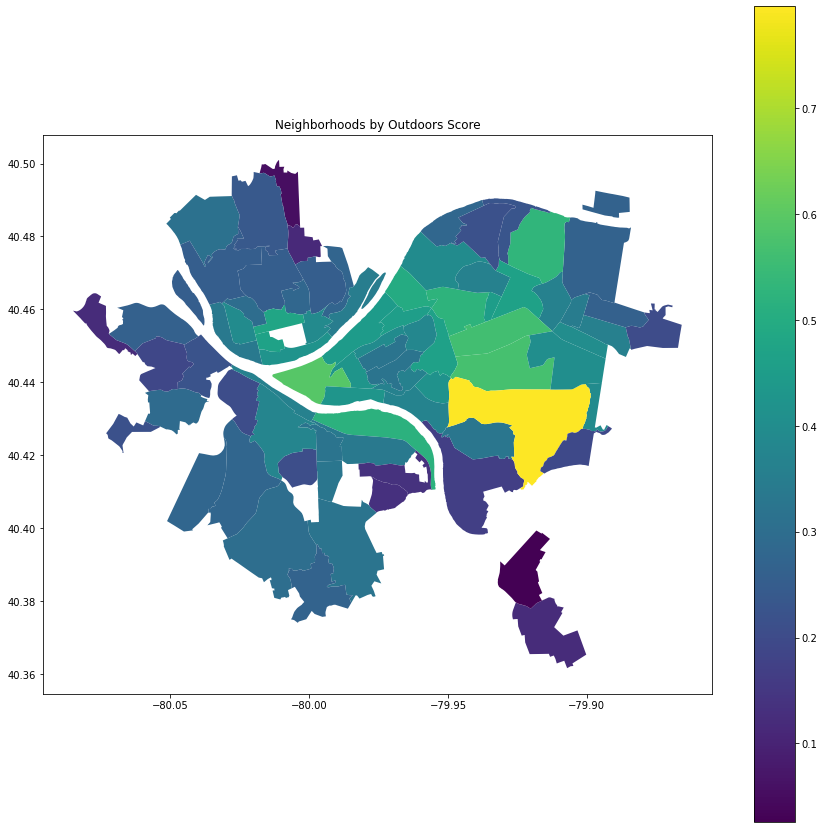

In [128]:
neighborhood_by_score = neighborhoods.merge(combined_metrics, on="hood")
neighborhood_by_score.plot(column="Outdoors Score", legend=True, figsize=(15, 15))
plt.title("Neighborhoods by Outdoors Score")

# Conclusions

## Richie
It is no surprise that Squirrel Hill South is the winner for outdoors-yness. While I am not entirely familiar with the different neighborhoods in Pittsburgh, I am familiar with the parks, of which many reside in Squirrel Hill South. This can be seen with how high the tree property value metric was for this neighborhood. However, it is surprising to see the relatively low walkability score. This likely has to do with that proprietary metric measuring a different type of walkability focusing more on nearby amenities, attractions, and services. Overall I think this was a satisfactory decision for the best neighborhood in Pittsburgh.

## Leigh
Based on the metrics we chose, it makes a lot of sense that Squirrel South would come out on top. While areas closer to the urban center of Pittsburgh might have more available amenities (and therefore a higher Walk Score), Squirrel Hill can't be beat when it comes to parks and overall greenery. For people who love the outdoors it is a shoe-in for the most livable neighborhood.

## Dan

Although Brighton Heights has the most number of playing fields, I believe that Squirrel Hill South wins the competition for outdoors-yness. This is because Squirrel Hill South wins the other two categories by a lot and I believe having two less fields does not make it any less outdoorsy. Some of these places just have multiple fields in one area, which does not make it more outdoors-y because it reflects one spot not the entire area. Therefore, my overall conclusion is that Squirrel Hill South is the overall winner. 